In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import matplotlib.pyplot as plt
import os
import quadprog
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'winequality-red.csv', 'archive.zip']


In [2]:
df = pd.read_csv("../input/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


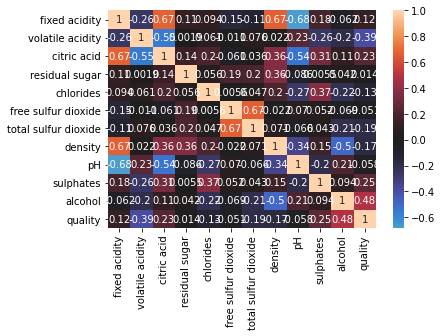

In [3]:
ax = sns.heatmap(df.corr(), annot=True, center = 0)

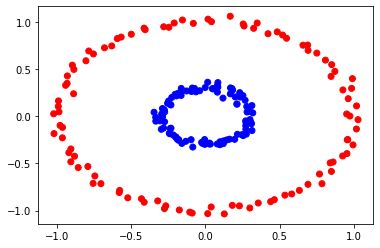

In [4]:
from sklearn import datasets
from sklearn import decomposition
X, y = datasets.make_circles(n_samples=200, factor=.3,noise=0.025)

#KPCA = decomposition.KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components = 10, gamma=10).fit(X)
#X_PCA = 0.1*KPCA.transform(X)

plt.scatter(X[:,0],X[:,1],c=list(map(lambda x:'b' if x == 1 else 'r',y)))
plt.show()
#plt.scatter(X_PCA[:,0],X_PCA[:,1],c=list(map(lambda x:'b' if x == 1 else 'r',y)))
#plt.show()

In [5]:
def mercerK(x_i,x_j):
    q = 5
    return 0.1*np.exp(-q*np.square(np.linalg.norm(x_i-x_j)))

n = len(X)
d = len(X.T)
C = 1
K = np.zeros((n,n))

def quadprog_solve_qp(P, q, G=None, h=None, G2=None, h2=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G, G2]).T
        qp_b = -np.hstack([b, h, h2])
        meq = A.shape[0]
    else:
        qp_C = -np.vstack([G, G2]).T
        qp_b = -np.hstack([h, h2])
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

for i in range(0,n):
    for j in range(0,n):
        if i >= j:
            k = mercerK(X[i], X[j])
            K[i,j] = k
            K[j,i] = k
            


#Q = np.concatenate((np.concatenate((K,-K),axis=1),np.concatenate((-K,K),axis=1)),axis = 0)
#r = np.concatenate((eps*np.ones(n)-y.T,eps*np.ones(n)+y.T),axis=1).reshape(-1)
#y_b = np.concatenate((np.ones(n).T,-np.ones(n).T),axis=0).reshape(-1)


Q = K + 0.00000000000001*np.identity(n)     
q = -K.diagonal()
G = -1*np.identity(n)
G2 = np.identity(n)
h = np.zeros(n)
h2 = C * np.ones(n)
b = np.zeros(n)
A = np.zeros((n,n))
A[0] = np.ones(n)

res = quadprog_solve_qp(Q, q, G=G, G2=G2, h=h, h2=h2,A=None, b=None)
print(np.sum((res >0) & (res < C)),np.sum((res==C)))
mask = (res >0) & (res < C)

106 0


In [6]:
points = np.zeros(n)
Kconst = 0
for t in range(0,n):
    if mask[t]:
        for s in range(0,n):
            if mask[s]:
                Kconst+=res[t]*res[s]*K[t,s]
def inside(x):
    x = x.reshape(-1,)
    point=mercerK(x,x) + Kconst
    for j in range(0,n):
        if mask[j]:
            point-=2*res[j]*mercerK(X[j],x)
    return point
for i in range(0,n):
    points[i] = inside(X[i])
r = points[mask].max()
mask_2 = points <= r
mask_3 = res==C
print(len(points[mask_2]))

200


In [7]:
def adjacent(x_i,x_j):
    for i in range(0,19):
        v = x_i-x_j
        inner = ((i+1)/20) * v
        if inside(inner) > r:
            return 0
    return 1


inside_p = X[mask_2]
n_p=len(inside_p)
adj = np.zeros([n_p,n_p])
for i in range(0,n_p):
    #print(i)
    for j in range(0,n_p):
        if j>i:
            adj[i,j] = adjacent(inside_p[i],inside_p[j])
            adj[j,i] = adj[i,j]
        if j==i:
            adj[i,i] = 1.0
print(adj)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [8]:
classified = {}
class_ = {}
grey = set()
def find_cluster(i):
    if i in grey:
        return
    if i not in class_:
        class_[i] = i
        classified[i] = set([i])
    for j in range(0,n_p):
        if adj[i,j]:
            class_[j] = class_[i]
            classified[class_[i]].add(j)
    grey.add(i)
    l_classified = classified[class_[i]].copy()
    for k in l_classified:
        find_cluster(k)
for i in range(0,n_p):
    find_cluster(i)
#print(classified)

In [9]:
clas = np.zeros(n)
c = 0
cl = 0
classes_2 = {}
print(np.sum(mask_2))
for i in range(0,n):
    if mask_2[i]:
        for k, v in classified.items():
            if c in set(v):
                if k not in classes_2:
                    cl += 1
                    classes_2[k] = cl
                clas[i] = classes_2[k]
    c+= 1
                
print(clas)

200
[1. 2. 2. 1. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 1.
 1. 2. 2. 1. 1. 2. 1. 1. 2. 1. 1. 2. 2. 1. 2. 2. 1. 2. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2.
 1. 1. 2. 2. 1. 2. 1. 2. 1. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 2. 1. 1. 2.
 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 1. 1. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 1. 1. 2. 1. 2. 1.
 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 1.
 2. 2. 2. 1. 1. 1. 2. 2.]


0 1 0


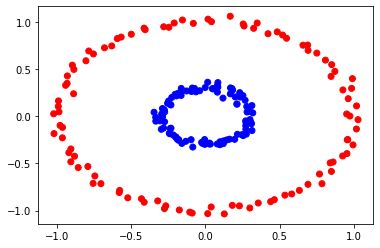

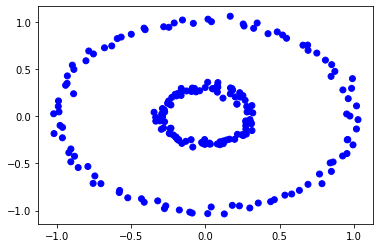

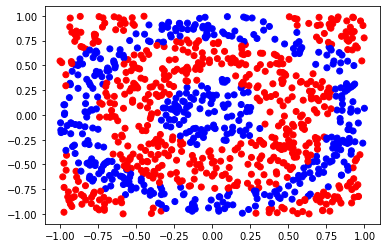

In [10]:
x = 2*np.random.rand(2,1000)-1


def color(c):
    if c == 0:
        return 'g'
    elif c == 1:
        return 'b'
    elif c == 2:
        return 'r'
    elif c == 3:
        return 'c'
    elif c == 4:
        return 'y'
    elif c == 5:
        return 'teal'
    else:
        return 'k'
def new_color(x):
    i = inside(x)
    if i <= r:
        return 'b'
    if i > r:
        return 'r'
    return 'g'

x_1 = np.zeros((3,2))
x_1[0][0] = -1
x_1[1][0] = -0.3

print(adjacent(x_1[0],x_1[1]),adjacent(x_1[1],x_1[2]),adjacent(x_1[0],x_1[2]))

plt.scatter(X[:,0],X[:,1],c=list(map(color,clas)))
plt.show()

plt.scatter(X[:,0],X[:,1],c=list(map(new_color,X)))
plt.show()

plt.scatter(x[0],x[1],c=list(map(new_color,x.T)))
plt.show()